In [1]:
import requests
import lxml.html as lh
import numpy as np
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
import pandas as pd
import re
from datetime import datetime

#print(page.text)

In [2]:
#Function only returns data for the top league from region (As decided by itsrugby.com)
def league_year_stats(soup):
    count = 0
    result_array = []

    for result in soup.find_all('tr'):
        for result2 in result.find_all('td', attrs = {"align": "center", "id": "noir"}):
            #print(len(list(result2.contents)))
            if (count>7 and count <32):
                    #print(result2.contents)
                try:
                    result_array.append(float(result2.contents[0]))
                except: 
                    result_array.append(np.nan)
            count+=1
    return(result_array)
### Make inside for loup a function
def league_stats(region_key, league_str):
    URL = 'https://www.itsrugby.co.uk/' + region_key + '.html'
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')
    url_tails = []
    url_head = 'https://www.itsrugby.co.uk/'
    league_stats_dict = {'league': [], 'year': [], 'tries_avg': [], 'tries_nb': [], 'conv_avg': [], 'conv_nb': [], 'pen_avg': [], 'pen_nb': [], 'dg_avg': [], 'dg_nb': []}
    result_ind = [0,0, 1,0,7,6,13,12,19,18]
    for a_href in soup.find_all('a', href=True):
        if (str(a_href['href'])[0:7] == 'result-'):
            url_tails.append(str(a_href['href'])[6:])
    #print(url_tails)
    for i in range(len(url_tails)):
        URL = url_head + 'stats' + url_tails[i]
        #print(URL)
        page = requests.get(URL)
        soup = BeautifulSoup(page.text, "html.parser")
        year = URL[-9:-5]
        result_array = league_year_stats(soup)
        for k in range(8):
            try:
                league_stats_dict[list(league_stats_dict.keys())[k+2]].append(result_array[result_ind[k+2]])
            except IndexError: 
                league_stats_dict[list(league_stats_dict.keys())[k+2]].append(np.nan)
    
        league_stats_dict['year'].append(float(year))
        league_stats_dict['league'].append(league_str)
        #print(pd.DataFrame.from_dict(league_stats_dict))
    return(pd.DataFrame.from_dict(league_stats_dict))

In [3]:
ml_leagues = ['englandpremiership', 'top14', 'superrugby', '6nationstournament', 'heinekencup']
archive_links = ['archives-irluk', 'archives-fr', 'archives-hemsud', 'archives-int', 'archives-cupeurope']
league_dataframes = []
for i in range(len(ml_leagues)):
    league_dataframes.append(league_stats(archive_links[i], ml_leagues[i]))
ml_stats_df = pd.concat(league_dataframes, ignore_index=True)
ml_stats_df = ml_stats_df.drop(ml_stats_df[(ml_stats_df.league == 'superrugby') & (ml_stats_df.year == '2019')].index)
#Error with 2019-2020 super rugby data not matching other data sources

In [11]:
ml_stats_df['games'] = ml_stats_df['tries_nb'] / ml_stats_df['tries_avg']
ml_stats_df['conv_rate'] = ml_stats_df['conv_avg'] / ml_stats_df['conv_avg']
ml_stats_df['tcp_avg'] = (ml_stats_df['tries_avg']*5) + (ml_stats_df['conv_avg']*2) + (ml_stats_df['pen_avg']*3)
ml_stats_df['tcp_nb'] = ml_stats_df['tcp_avg'] * ml_stats_df['games']

In [12]:
X = np.arange(ml_stats_df['year'].min(), ml_stats_df['year'].max() +1)
y_tries = ml_stats_df.groupby('year').sum()['tries_nb'] / ml_stats_df.groupby('year').sum()['games']
y_pen = ml_stats_df.groupby('year').sum()['pen_nb'] / ml_stats_df.groupby('year').sum()['games']
y_tcp = ml_stats_df.groupby('year').sum()['tcp_nb'] / ml_stats_df.groupby('year').sum()['games']
idx = np.isfinite(X) & np.isfinite(y_tries) & (X >= 2010)
tries_fit = np.polyfit(X[idx], y_tries[idx], 1)
idx = np.isfinite(X) & np.isfinite(y_pen) & (X >= 2010)
pen_fit = np.polyfit(X[idx], y_pen[idx], 1)
idx = np.isfinite(X) & np.isfinite(y_tcp) & (X >= 2010)
tcp_fit = np.polyfit(X[idx], y_tcp[idx], 1)
print(tries_fit, pen_fit)

[ 1.57797637e-01 -3.13233803e+02] [-2.40407933e-01  4.88977958e+02]


In [13]:
y_tries_fit = X*tries_fit[0] + tries_fit[1]
y_pen_fit = X*pen_fit[0] + pen_fit[1]
y_tcp_fit = X*tcp_fit[0] + tcp_fit[1]
print(y_tries_fit)

[1.572482   1.73027963 1.88807727 2.04587491 2.20367254 2.36147018
 2.51926782 2.67706545 2.83486309 2.99266073 3.15045836 3.308256
 3.46605364 3.62385127 3.78164891 3.93944655 4.09724418 4.25504182
 4.41283946 4.5706371  4.72843473 4.88623237 5.04403001 5.20182764
 5.35962528 5.51742292 5.67522055]


Text(0.5, 1.0, 'Points from Tries, Conversions, and Penalty Goals per Game Since 2010')

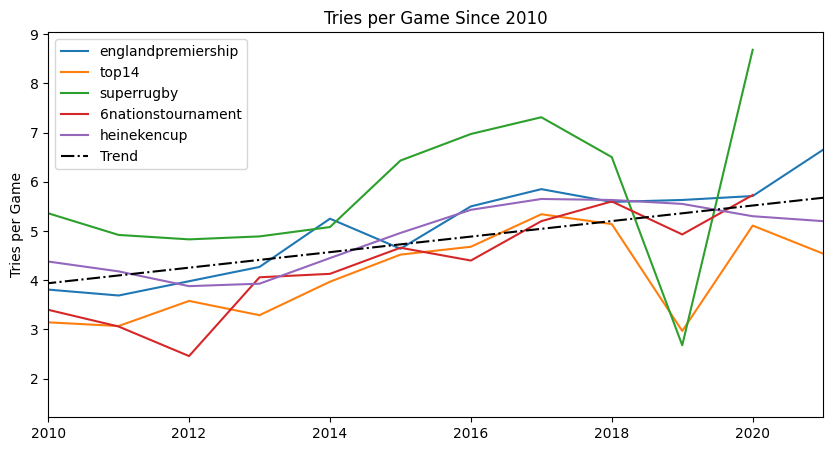

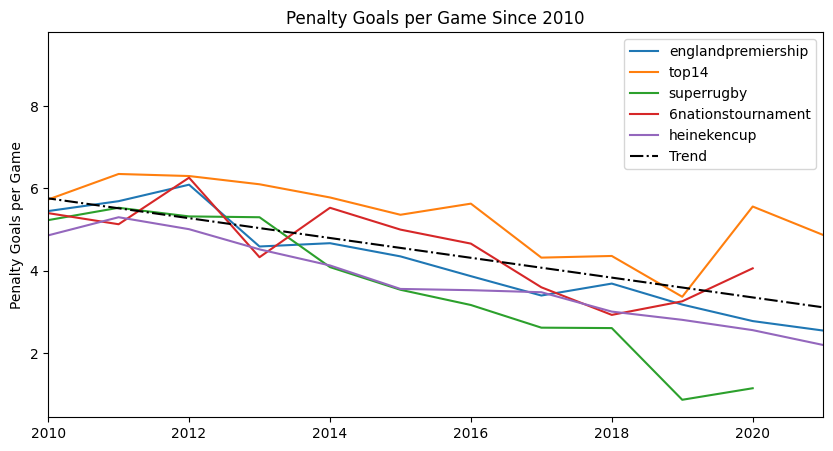

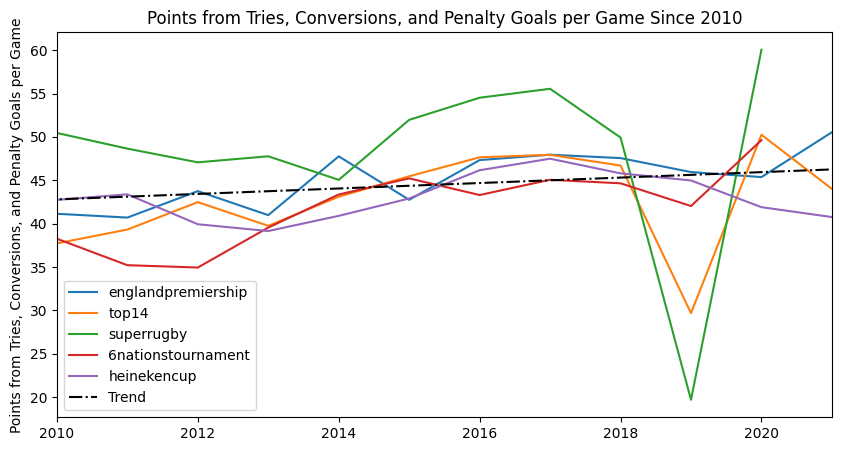

In [14]:

plt.figure(figsize=(10,5))
count = 2
for league in ml_leagues:
    plt.plot(ml_stats_df[ml_stats_df['league'] == league]['year'], ml_stats_df[ml_stats_df['league'] == league]['tries_avg'])
plt.plot(X, y_tries_fit, linestyle = '-.', color = 'black')
plt.legend(ml_leagues + list(['Trend']))
plt.xlim([2010, 2021])
plt.ylabel('Tries per Game')
plt.title('Tries per Game Since 2010')
plt.figure(figsize=(10,5))
count = 2
for league in ml_leagues:
    plt.plot(ml_stats_df[ml_stats_df['league'] == league]['year'], ml_stats_df[ml_stats_df['league'] == league]['pen_avg'])
plt.plot(X, y_pen_fit, linestyle = '-.', color = 'black')
plt.legend(ml_leagues + list(['Trend']))
plt.xlim([2010, 2021])
plt.ylabel('Penalty Goals per Game')
plt.title('Penalty Goals per Game Since 2010')

plt.figure(figsize=(10,5))
count = 2
for league in ml_leagues:
    plt.plot(ml_stats_df[ml_stats_df['league'] == league]['year'], ml_stats_df[ml_stats_df['league'] == league]['tcp_avg'])
plt.plot(X, y_tcp_fit, linestyle = '-.', color = 'black')
plt.legend(ml_leagues + list(['Trend']))
plt.xlim([2010, 2021])
plt.ylabel('Points from Tries, Conversions, and Penalty Goals per Game')
plt.title('Points from Tries, Conversions, and Penalty Goals per Game Since 2010')


In [165]:
#Generate league name csv
leagues = ['top14', 'prod2', 'federale1', 'englandpremiership', 'pro14', 'englishchampionship', 'superrugby', 'itmcup', 'curriecup', 'urbatop14']
league_name_arr = np.zeros((len(leagues), 10)).astype(str)

for i in range(len(leagues)):
    league_name_arr[i,:] = leagues[i]  

In [166]:
leagues = ['top14', 'prod2', 'federale1', 'englandpremiership', 'pro14', 'englishchampionship', 'superrugby', 'itmcup', 'curriecup', 'urbatop14']
years = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']
for i in range(len(leagues)):
    league_stats = {'tries_avg': [], 'tries_nb': [], 'conv_avg': [], 'conv_nb': [], 'pen_avg': [], 'pen_nb': [], 'dg_avg': [], 'dg_nb': []}
    for j in range(len(years)):
        URL = 'https://www.itsrugby.co.uk/stats-{league}-{year}.html'.format(league = leagues[i], year = years[j])
        #rint(URL)
        page = requests.get(URL)
        soup = BeautifulSoup(page.text, "html.parser")
        result_array = []
        count = 0
        if(len(list(soup.find_all('tr'))) <50 ):
            league_name_arr[i,j] = 'error'

    


In [ ]:
x_error = []
y_error = []
count = 0
for i in range(league_name_arr.shape[0]):
    for j in range(league_name_arr.shape[1]):
        if(league_name_arr[i,j] == 'error'):
            print(leagues[i], years[j])
            print(i,j)
            x_error.append(i)
            y_error.append(j)
            count += 1
            print(count)

In [179]:
error_fixes = ['federale1', 'avivapremiership', 'avivapremiership', 'avivapremiership', 'avivapremiership', 'avivapremiership','avivapremiership', 'avivapremiership', 'premiershiprugby', 'rabodirect12', 'rabodirect12', 'rabodirect12', 'guinesspro12', 'guinesspro12', 'pro12rugby', 'guinesspro14', 'guinesspro14', 'angleterred21', 'angleterred21', 'englandchampionship', 'englandd1', 'englandd1', 'mitre10cup', 'mitre10cup', 'urbatop12', 'urbatop12', 'urbatop12', 'error', 'urbatop12']
for i in range(len(error_fixes)):
    league_name_arr[x_error[i], y_error[i]] = error_fixes[i]


In [180]:
from bs4 import BeautifulSoup
leagues_10yr_stats = {}
years = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']
result_ind = [1,0,7,6,13,12,19,18]
result_stat = ['league', 'year', 'tries_avg', 'tries_nb', 'conv_avg', 'conv_nb', 'pen_avg', 'pen_nb', 'dg_avg', 'dg_nb']
league_stats = {'league': [], 'year': [], 'tries_avg': [], 'tries_nb': [], 'conv_avg': [], 'conv_nb': [], 'pen_avg': [], 'pen_nb': [], 'dg_avg': [], 'dg_nb': []}

for i in range(len(leagues)):
    for j in range(len(years)):
        URL = 'https://www.itsrugby.co.uk/stats-{league}-{year}.html'.format(league = league_name_arr[i,j], year = years[j])
        #rint(URL)
        page = requests.get(URL)
        soup = BeautifulSoup(page.text, "html.parser")
        result_array = league_year_stats(soup)
        for k in range(8):
            try:
                league_stats[result_stat[k+2]].append(result_array[result_ind[k]])
            except IndexError: 
                league_stats[result_stat[k+2]].append(np.nan)
                print(URL)
        league_stats['league'].append(league_name_arr[i,j])
        league_stats['year'].append(int(years[j]))
league_10yr_df = pd.DataFrame.from_dict(league_stats)

[559.0, 3.07, 352.0, 1.93, 207.0, 1.13, 449.0, 2.46, 283.0, 1.55, 166.0, 0.91, 1157.0, 6.35, 672.0, 3.69, 485.0, 2.66, 60.0, 0.32, 30.0, 0.16, 30.0, 0.16]
[653.0, 3.58, 417.0, 2.29, 236.0, 1.29, 518.0, 2.84, 341.0, 1.87, 177.0, 0.97, 1148.0, 6.3, 660.0, 3.62, 488.0, 2.68, 59.0, 0.32, 29.0, 0.15, 30.0, 0.16]
[600.0, 3.29, 417.0, 2.29, 183.0, 1.0, 455.0, 2.5, 318.0, 1.74, 137.0, 0.75, 1111.0, 6.1, 621.0, 3.41, 490.0, 2.69, 52.0, 0.28, 27.0, 0.14, 25.0, 0.13]
[724.0, 3.97, 479.0, 2.63, 245.0, 1.34, 540.0, 2.96, 352.0, 1.93, 188.0, 1.03, 1053.0, 5.78, 562.0, 3.08, 491.0, 2.69, 42.0, 0.23, 15.0, 0.08, 27.0, 0.14]
[824.0, 4.52, 517.0, 2.84, 307.0, 1.68, 617.0, 3.39, 384.0, 2.1, 233.0, 1.28, 976.0, 5.36, 526.0, 2.89, 450.0, 2.47, 19.0, 0.1, 9.0, 0.04, 10.0, 0.05]
[853.0, 4.68, 528.0, 2.9, 325.0, 1.78, 671.0, 3.68, 425.0, 2.33, 246.0, 1.35, 1026.0, 5.63, 571.0, 3.13, 455.0, 2.5, 24.0, 0.13, 17.0, 0.09, 7.0, 0.03]
[973.0, 5.34, 600.0, 3.29, 373.0, 2.04, 754.0, 4.14, 480.0, 2.63, 274.0, 1.5, 787

[779.0, 5.64, 441.0, 3.19, 338.0, 2.44, 540.0, 3.91, 310.0, 2.24, 230.0, 1.66, 516.0, 3.73, 249.0, 1.8, 267.0, 1.93, 4.0, 0.02, 2.0, 0.01, 2.0, 0.01]
[784.0, 5.93, 425.0, 3.21, 359.0, 2.71, 520.0, 3.93, 289.0, 2.18, 231.0, 1.75, 411.0, 3.11, 198.0, 1.5, 213.0, 1.61, 7.0, 0.05, 5.0, 0.03, 2.0, 0.01]
[819.0, 6.2, 432.0, 3.27, 387.0, 2.93, 573.0, 4.34, 313.0, 2.37, 260.0, 1.96, 372.0, 2.81, 193.0, 1.46, 179.0, 1.35, 11.0, 0.08, 5.0, 0.03, 6.0, 0.04]
[787.0, 6.39, 404.0, 3.28, 383.0, 3.11, 536.0, 4.35, 281.0, 2.28, 255.0, 2.07, 326.0, 2.65, 170.0, 1.38, 156.0, 1.26, 12.0, 0.09, 4.0, 0.03, 8.0, 0.06]
[931.0, 7.05, 493.0, 3.73, 438.0, 3.31, 675.0, 5.11, 368.0, 2.78, 307.0, 2.32, 350.0, 2.65, 186.0, 1.4, 164.0, 1.24, 4.0, 0.03, 3.0, 0.02, 1.0, 0.0]
[917.0, 6.94, 481.0, 3.64, 436.0, 3.3, 645.0, 4.88, 338.0, 2.56, 307.0, 2.32, 253.0, 1.91, 139.0, 1.05, 114.0, 0.86, 5.0, 0.03, 2.0, 0.01, 3.0, 0.02]
[525.0, 3.97, 282.0, 2.13, 243.0, 1.84, 367.0, 2.78, 199.0, 1.5, 168.0, 1.27, 206.0, 1.56, 108.0, 

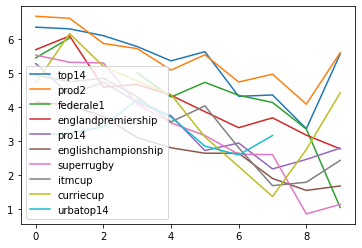

In [185]:
#print(leagues_10yr_stats)
for key, value in leagues_10yr_stats.items():
    plt.plot(value['pen_avg'])
#plt.labels = leagues_10yr_stats.keys()
plt.legend(leagues_10yr_stats.keys())

Scraping Player Data

    Go to player stats and go through league by league grabbing each players data
    Collect Name/Id, Age, League, Previous League, Tries, Games
    Add to pandas dataframe and save as csv

In [ ]:
from bs4 import BeautifulSoup
leagues_10yr_stats = {}
years = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']
result_ind = [1,0,7,6,13,12,19,18]
result_stat = ['tries_avg', 'tries_nb', 'conv_avg', 'conv_nb', 'pen_avg', 'pen_nb', 'dg_avg', 'dg_nb']
for i in range(len(leagues)):
    league_stats = {'tries_avg': [], 'tries_nb': [], 'conv_avg': [], 'conv_nb': [], 'pen_avg': [], 'pen_nb': [], 'dg_avg': [], 'dg_nb': []}
    for j in range(len(years)):
        URL = 'https://www.itsrugby.co.uk/mutation-{league}-{year}.html'.format(league = league_name_arr[i,j], year = years[j])
        #rint(URL)
        page = requests.get(URL)
        soup = BeautifulSoup(page.text, "html.parser")
        

In [50]:
leagues = ['top14', 'prod2', 'federale1', 'englandpremiership', 'unitedrugbychampionship', 'englandchampionship', 'superrugby', 'curriecupfirstdiv', 'urbatop13', 'japan', 'majorleaguerugby']
player_links = []
for i in range(len(leagues)):
    URL = 'https://www.itsrugby.co.uk/players/competitions/{}.html#'.format(leagues[i])
    page = requests.get(URL)
    soup = BeautifulSoup(page.text, "html.parser")
    for link in soup.findAll('a'):
        #print(link.get('href'))
        if(str(link.get('href'))[21:28] == 'players'):
            #print(str(link.get('href'))[2:])
            player_links.append(str(link.get('href'))[2:])

In [52]:
fp = open(r'player_link.txt', 'w')
for link in player_links:
    fp.write('{}\n'.format(link))
fp.close()

In [9]:
def player_data(URL):
    URL = 'https://' + URL
    page = requests.get(URL)
    soup = BeautifulSoup(page.text, "html.parser")
    ##print(URL)
    count = 0
    result_array = []
    start = False
    stats_dict = {'player_id': [], 'birthdate': [], 'pos': [], 'year': [], 'team': [], 'competition': [], 'pts': [], 'played': [], 'start': [], 'try': [], 'pen': [], 'dp': [], 'tr': [], 'yellow': [], 'red': [], 'min': []}
    string = str(soup.find_all('span')[1].contents)
    split_string = string.split('xa0')
    pos = split_string[1][:-2]
    try:
        string2 = str(soup.find_all('p')[1])
        match = re.search(r'\d{2}/\d{2}/\d{4}', string2)
        bd = match.group(0)
    except:
        bd = np.nan
    tr_count = 0
    for result in soup.find_all('tr'):
        ##print('row', tr_count)
        tr_count += 1
        if((start) & ('tr class=\"itsBlue1\"' in str(result))):
            #print(str(result))
            break;
        #if(result.find_all('td')[0].contents[0] == 'Competitions'):
            #break;
        ##print('hi', str(result.find_all('td')[0]))
        if((start) & ('style=' in str(result.find_all('td')[0]))):
            stats_dict['year'].append(stats_dict['year'][-1])
            track = 1
        elif((start) & (str(result.find_all('td')[0].contents[0])[0] not in ['0', '1', '2', '9'])):
            stats_dict['year'].append(stats_dict['year'][-1])
            stats_dict['team'].append(stats_dict['team'][-1])
            ##print(str(result.find_all('td')[0].contents[0])[0])
            track = 4
        else:
            track = -1
        keys = list(stats_dict.keys())
        k = 7
        for result2 in result.find_all('td'):
            if(start):
                track += 1   
            #print('track', track)
            #print('count', count)
            #print(result2.contents)

            if(track == 0):
                if(len(str(result2.contents[0])) == 5):
                    stats_dict['year'].append(int('20' + result2.contents[0][:2]))
                else:
                    stats_dict['year'].append(int(str(result2.contents[0])))

            if(track == 2):
                a = result2.find('a').contents[0]
                stats_dict['team'].append(a)
            if(track == 5):
                ##print(result2.contents)
                stats_dict['competition'].append(result2.contents[0])
                stats_dict['player_id'].append(URL[35:-6])
                stats_dict['pos'].append(pos)
                stats_dict['birthdate'].append(bd)
                #dlkjasl = 0
            if(track == 7):
                if(result2.contents[0] == 'No data'):
                    ##print(result2.contents[0])
                    for i in range(len(keys[6:])):
                        stats_dict[keys[i+6]].append(np.nan)
                    break;
                else:
                    try:
                        stats_dict['pts'].append(float(result2.contents[0]))
                    except:
                        stats_dict['pts'].append(0.0)

            if((track > 7) & (track%2 !=0) & (track != 25)):
                try:
                    a = float(result2.find('a').contents[0])
                    stats_dict[keys[k]].append(a)
                except:
                    stats_dict[keys[k]].append(0.0)
                k += 1
        
            if(track == 25):
                a = result2.contents[0]
                try:
                    stats_dict['min'].append(float(a))
                except:
                    stats_dict['min'].append(0.0)
            if((count == 25) & (~start)):
                ##print(result2.contents[0])
                if(len(str(result2.contents[0])) == 5):
                    stats_dict['year'].append(int('20' + result2.contents[0][:2]))
                else:
                    stats_dict['year'].append(int(str(result2.contents[0])))
                start = True
                track += 1
        
            count += 1
    #print(stats_dict)
    return(pd.DataFrame.from_dict(stats_dict)) 
        

In [2]:
player_links = open('player_link.txt').readlines()


In [19]:
#Function works for all players with valid pages. 19 links do not have valid pages and are thus skipped
player_dfs = []
bad_players = []
count_success = 0
count_fail = 0
player_links_len = len(player_links)
for i in range(player_links_len):
    try:
        player_dfs.append(player_data(player_links[i][:-1]))
        count_success += 1
    except:
        bad_players.append(player_links[i][:-1])
        count_fail += 1
    #rint(i)
    if((i%100) == 0):
        print(str((i/player_links_len) * 100) + '%')
        print((count_fail / (count_fail + count_success))*100)
print('failed: ' + str(count_fail) + 'succeeded: ' + str(count_success))

NameError: name 'player_links' is not defined

In [11]:
players_df = pd.concat(player_dfs, ignore_index = True)

In [ ]:
compression_opts = dict(method='zip', archive_name='itsrugby_players.csv')
df.to_csv('itsrugby_players.zip', index=False, compression=compression_opts)

In [84]:
players_df = pd.read_csv('itsrugby_players.zip')

In [85]:
def age(row):
    birthdate = str(row['birthdate'])
    ref_year = row['year']
    ref_date =  '07/01/' + str(ref_year)
    ref_date = datetime.strptime(ref_date, '%d/%m/%Y')
    birthdate_strp = datetime.strptime(birthdate, '%d/%m/%Y')
    age = ref_date.year - birthdate_strp.year - ((ref_date.month, ref_date.day) < (birthdate_strp.month, birthdate_strp.day))
    return age

def prev_year_league(row, df):
    player_id = row['player_id']
    year = row['year']
    prev_year = df[(df['year'] - year == -1) & (df['player_id'] == player_id)]
    if(len(prev_year['competition']) > 1):
        prev_league = np.nan
    elif(len(prev_year['competition']) > 0):
        prev_league = np.array(prev_year['competition'])[0]
    else:
        prev_league = np.nan
    return prev_league

def prev_year_min(row, df):
    player_id = row['player_id']
    year = row['year']
    prev_year = df[(df['year'] - year == -1) & (df['player_id'] == player_id)]
    if(len(prev_year['competition']) > 1):
        prev_min = np.nan
    if(len(prev_year['min']) > 0):
        prev_min = np.array(prev_year['min'])[0]
    else:
        prev_min = np.nan
    return prev_min

def prev_year_played(row, df):
    player_id = row['player_id']
    year = row['year']
    prev_year = df[(df['year'] - year == -1) & (df['player_id'] == player_id)]
    if(len(prev_year['competition']) > 1):
        prev_played = np.nan
    if(len(prev_year['played']) > 0):
        prev_played = np.array(prev_year['played'])[0]
    else:
        prev_played = np.nan
    return prev_played

def prev_year_start(row, df):
    player_id = row['player_id']
    year = row['year']
    prev_year = df[(df['year'] - year == -1) & (df['player_id'] == player_id)]
    if(len(prev_year['competition']) > 1):
        prev_start = np.nan
    if(len(prev_year['start']) > 0):
        prev_start = np.array(prev_year['start'])[0]
    else:
        prev_start = np.nan
    return prev_start

def career_minutes(row, df):
    player_id = row['player_id']
    year = row['year']
    df_player = df[(df['player_id'] == player_id) & (df['year'] < year)]
    minutes = np.sum(np.array(df_player['min']))
    return minutes
    

def career_played(row, df):
    player_id = row['player_id']
    year = row['year']
    df_player = df[(df['player_id'] == player_id)& (df['year'] < year)]
    played = np.sum(np.array(df_player['played']))
    return played

def career_start(row, df):
    player_id = row['player_id']
    year = row['year']
    df_player = df[(df['player_id'] == player_id)& (df['year'] < year)]
    start = np.sum(np.array(df_player['start']))
    return start


In [86]:
players_df = players_df.dropna(axis=0)
players_df['age'] = players_df.apply(lambda row: age(row), axis=1)
players_df = players_df.drop_duplicates()

leagues = ['Top 14', 'Pro D2', 'PRO 14', 'ITM Cup', 'Super Rugby', 'NPC', 'Rabodirect PRO12', 'National Rugby Championship',  'United rugby championship',  'Air New Zealand Cup', 'MITRE 10 CUP',  'Currie Cup', 'Guinness Premiership', 'England Premiership', 'England Championship',  'Super 10', 'Super 14', 'Provincial Cup', 'England Cup',  'Super 12', 'Top 16',   'Celtic League']
players_df = players_df[players_df.competition.isin(leagues)]
league_names = [['Top 14', 'Top 16'], ['United Rugby Championship', 'United rugby championship', 'PRO 14', 'Celtic League', 'Rabodirect PRO12'], ['NPC', 'ITM Cup', 'MITRE 10 CUP', 'Provincial Cup', 'Air New Zealand Cup'],  ['England Premiership', 'Guinness Premiership'], ['Super Rugby', 'Super 12', 'Super 10', 'Super 14'], ['England Championship', 'England Cup']]
for i in range(len(league_names)):
    players_df.loc[players_df['competition'].isin(league_names[i]), ['competition']] = league_names[i][0]

In [87]:
players_df = players_df[players_df['min'] > 0]
players_df = players_df[players_df['played'] >0]
players_df['prev_year_competition'] = players_df.apply(lambda row: prev_year_league(row, players_df), axis=1)
players_df['prev_year_min'] = players_df.apply(lambda row: prev_year_min(row, players_df), axis=1)
players_df['prev_year_played'] = players_df.apply(lambda row: prev_year_played(row, players_df), axis=1)
players_df['career_min'] = players_df.apply(lambda row: career_minutes(row, players_df), axis=1)
players_df['career_played'] = players_df.apply(lambda row: career_played(row, players_df), axis=1)
players_df['prev_year_start'] = players_df.apply(lambda row: prev_year_start(row, players_df), axis=1)
players_df['career_start'] = players_df.apply(lambda row: career_start(row, players_df), axis=1)
players_df['min_avg'] = players_df['min']/players_df['played']
players_df['prev_year_min_avg'] = players_df['prev_year_min']/players_df['prev_year_played']
players_df['career_min_avg'] = players_df['career_min']/players_df['career_played']
players_df['prev_year_start_avg'] = players_df['prev_year_start']/players_df['prev_year_played']
players_df['career_start_avg'] = players_df['career_start']/players_df['career_played']

In [88]:
players_df['competition_change'] = players_df['prev_year_competition'] + " - " + players_df['competition']
players_df['league_change'] = players_df['prev_year_competition'] != players_df['competition']

In [89]:
players_df = players_df.dropna(axis=0)
players_df = pd.get_dummies(players_df, columns = ['competition_change'])

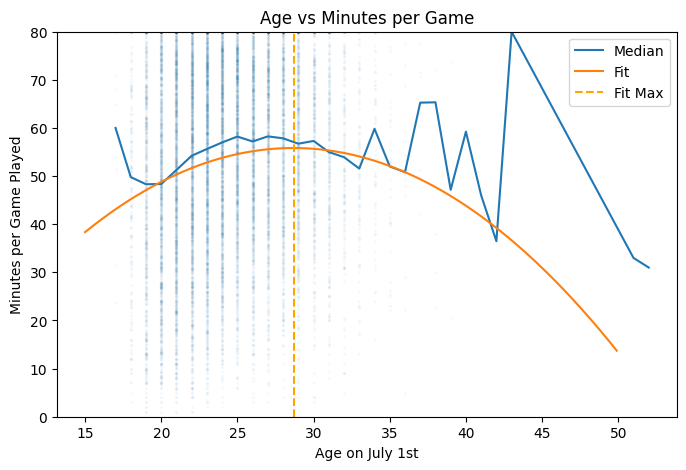

In [90]:
plt.figure(1, figsize=(8,5))
#plt.xlim([18, 42])
plt.ylim([0,80])
#plt.figure(2)
plt.plot(players_df.groupby('age').median()['min_avg'])
#plt.xlim([18,50])
X = np.array(players_df['age'])
y = np.array(players_df['min_avg'])
idx = np.isfinite(X) & np.isfinite(y)
fit = np.polyfit(X[idx],y[idx],2)
#plt.figure(3)
#print(fit)
X_fit = np.arange(15, 50, .1)
y_fit = (X_fit**2)*fit[0] + X_fit*fit[1] + fit[2]
plt.plot(X_fit, y_fit)
plt.plot([X_fit[y_fit.argmax()], X_fit[y_fit.argmax()]], [0,80], linestyle = '--', c='orange')
plt.legend(['Median', 'Fit', 'Fit Max'])
plt.scatter(players_df['age'], players_df['min_avg'], alpha = .025, s=2)
plt.xlabel('Age on July 1st')
plt.ylabel('Minutes per Game Played')
plt.title('Age vs Minutes per Game')
plt.show()
age_peak = X_fit[y_fit.argmax()]

In [91]:
players_df['age_pred'] = (players_df['age'] < age_peak)


In [92]:
columns = list(players_df.columns)
players_df = players_df[players_df['league_change']]
removals = ['age_pred', 'player_id', 'birthdate', 'pos', 'year', 'team', 'pts', 'played', 'start', 'try', 'pen', 'dp', 'tr', 'yellow', 'red', 'min', 'prev_year_min', 'prev_year_played', 'min_avg', 'career_played', 'career_min', 'competition', 'prev_year_competition', 'career_start', 'prev_year_start', 'league_change','career_start_avg',  'prev_year_start_avg']
for string in removals:
    columns.remove(string)
players_mod_df = players_df[columns]
players_mod_df.replace([np.inf, -np.inf], np.nan, inplace=True)
players_mod_df = players_mod_df.dropna(axis=0)

#print(players_mod_df.columns)

column_rem = []
for column in players_mod_df.columns:
    #print(column, players_mod_df[column].sum())
    if(players_mod_df[column].sum() < 25):
        column_rem.append(column)
        players_mod_df = players_mod_df[players_mod_df[column] <1]
        players_df = players_df[players_df[column] < 1]
columns = list(players_mod_df.columns)
for column in column_rem:
    columns.remove(column)
players_mod_df = players_mod_df[columns]



player_mod_y = (players_df['min_avg'] > players_df['prev_year_min_avg'])
age_base = np.where(players_df['age_pred'], 1, 0)
print(np.max(players_mod_df['age']))
players_mod_df['age'] = players_mod_df['age']/52
print(players_mod_df['age'])
players_mod_df['prev_year_min_avg'] = players_mod_df['prev_year_min_avg']/80
players_mod_df['career_min_avg'] = players_mod_df['career_min_avg']/80

print((players_df['age'].min()), players_df['age'].max(), players_df['prev_year_min'].min(), players_df['prev_year_min_avg'].max(), players_df['career_min'].min(), players_df['career_min_avg'].max())



37
18       0.423077
19       0.403846
20       0.384615
25       0.634615
27       0.596154
           ...   
51032    0.442308
51045    0.538462
51057    0.442308
51082    0.480769
51122    0.500000
Name: age, Length: 2503, dtype: float64
17 37 1.0 80.0 1.0 80.0


/var/folders/7v/_90wc0ds3jd2h03mn95j4sfc0000gn/T/ipykernel_7189/4016424436.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_mod_df.replace([np.inf, -np.inf], np.nan, inplace=True)


In [71]:
players_mod_df

,age,prev_year_min_avg,career_min_avg,career_start_avg,competition_change_Currie Cup - Super Rugby,competition_change_Currie Cup - United Rugby Championship,competition_change_England Championship - England Premiership,competition_change_England Premiership - England Championship,competition_change_England Premiership - Top 14,competition_change_England Premiership - United Rugby Championship,...,competition_change_Super Rugby - Currie Cup,competition_change_Super Rugby - England Premiership,competition_change_Super Rugby - NPC,competition_change_Super Rugby - National Rugby Championship,competition_change_Super Rugby - Top 14,competition_change_Top 14 - England Premiership,competition_change_Top 14 - Pro D2,competition_change_United Rugby Championship - England Championship,competition_change_United Rugby Championship - England Premiership,competition_change_United Rugby Championship - Top 14
18,0.423077,0.455682,0.395000,0.350000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,0.403846,0.557143,0.320833,0.277778,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
20,0.384615,0.160714,0.170455,0.090909,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,0.634615,0.894500,0.895577,0.903846,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27,0.596154,0.925000,0.892650,0.902778,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51032,0.442308,0.471875,0.530068,0.459459,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51045,0.538462,0.262500,0.336932,0.181818,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
51057,0.442308,0.412500,0.375000,0.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51082,0.480769,0.659375,0.702941,0.941176,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [172]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [ 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf', 'sigmoid', 'linear']}
X = np.array(players_mod_df)
y = np.where(player_mod_y, 1, 0)
params = {'C': [], 'gamma': [], 'kernel': []}
for i in range(500):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30)
    grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 0, n_jobs=8)
    grid.fit(X_train, y_train)
    params['C'].append(grid.best_params_['C'])
    params['gamma'].append(grid.best_params_['gamma'])
    params['kernel'].append(grid.best_params_['kernel'])
    if(i%10 == 0):
        print(i/500)

0.0
0.02
0.04
0.06
0.08
0.1
0.12
0.14
0.16
0.18
0.2
0.22
0.24
0.26
0.28
0.3
0.32
0.34
0.36
0.38
0.4
0.42
0.44
0.46
0.48
0.5
0.52
0.54
0.56
0.58
0.6
0.62
0.64
0.66
0.68
0.7
0.72
0.74
0.76
0.78
0.8
0.82
0.84
0.86
0.88
0.9
0.92
0.94
0.96
0.98


In [173]:
df = pd.DataFrame.from_dict(params)
print(df.groupby(df.columns.tolist(),as_index=False).size())

       C   gamma   kernel  size
0      1  0.1000   linear    12
1      1  0.1000      rbf     3
2      1  0.1000  sigmoid     1
3     10  0.0100      rbf     2
4     10  0.1000   linear    57
5     10  0.1000      rbf     6
6     10  0.1000  sigmoid   117
7    100  0.0100      rbf    22
8    100  0.0100  sigmoid     4
9    100  0.1000   linear    85
10   100  0.1000      rbf    14
11  1000  0.0001      rbf     1
12  1000  0.0010      rbf    34
13  1000  0.0010  sigmoid     3
14  1000  0.0100      rbf    21
15  1000  0.0100  sigmoid    64
16  1000  0.1000   linear    49
17  1000  0.1000      rbf     5


In [ ]:
linear 100 .1 

In [184]:
def test_500(X, y, model):

    test_acc = []
    train_acc = []
    baseline_acc = []
    for i in range(1000):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30)
        svc = svm.SVC(C = 100, gamma = .1, kernel = 'linear', random_state = 0)
        svc.fit(X_train, y_train)
        train_pred = svc.predict(X_train)
        test_pred = svc.predict(X_test)
        #print(accuracy_score(y_train, train_pred))
        #print(accuracy_score(y_test, test_pred))
        test_acc.append(accuracy_score(y_test, test_pred))
        train_acc.append(accuracy_score(y_train, train_pred))
        baseline_acc.append(1-np.mean(y_test))
    test_acc_mean = np.mean(np.array(test_acc))
    train_acc_mean = np.mean(np.array(train_acc))
    #print(np.mean(np.array(baseline_acc)))
    test_base_mean = np.mean(np.array(test_acc)) - np.mean(np.array(baseline_acc))
    return(test_acc_mean, train_acc_mean, test_base_mean)

In [185]:
X = np.array(players_mod_df)
y = np.where(player_mod_y, 1, 0)
print(test_500(X, y, svm.SVC(C = 100, gamma = .1, kernel = 'linear')))
print(test_500(X, y, svm.SVC(C = 10, gamma = .1, kernel = 'sigmoid')))
print(test_500(X, y, svm.SVC(C = 1000, gamma = .01, kernel = 'sigmoid')))

(0.7337110519307589, 0.744916095890411, 0.20749533954727029)
(0.7335033288948068, 0.7449554794520548, 0.2071531291611184)
(0.7345778961384819, 0.7446769406392694, 0.20800399467376807)


In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

X = np.array(players_mod_df)
y = np.where(player_mod_y, 1, 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33)



param_grid = {'n_estimators': [10, 50, 100, 500], 'max_depth': [None, 5, 15, 50]}
grid2 = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 3)
grid2.fit(X_train, y_train)
grid_predictions2 = grid2.predict(X_test)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ...max_depth=None, n_estimators=10;, score=0.711 total time=   0.0s
[CV 2/5] END ...max_depth=None, n_estimators=10;, score=0.658 total time=   0.0s
[CV 3/5] END ...max_depth=None, n_estimators=10;, score=0.687 total time=   0.0s
[CV 4/5] END ...max_depth=None, n_estimators=10;, score=0.639 total time=   0.0s
[CV 5/5] END ...max_depth=None, n_estimators=10;, score=0.719 total time=   0.0s
[CV 1/5] END ...max_depth=None, n_estimators=50;, score=0.720 total time=   0.1s
[CV 2/5] END ...max_depth=None, n_estimators=50;, score=0.673 total time=   0.0s
[CV 3/5] END ...max_depth=None, n_estimators=50;, score=0.713 total time=   0.1s
[CV 4/5] END ...max_depth=None, n_estimators=50;, score=0.684 total time=   0.1s
[CV 5/5] END ...max_depth=None, n_estimators=50;, score=0.755 total time=   0.0s
[CV 1/5] END ..max_depth=None, n_estimators=100;, score=0.711 total time=   0.1s
[CV 2/5] END ..max_depth=None, n_estimators=100;

In [26]:
print(grid2.best_params_)

{'max_depth': 15, 'n_estimators': 500}


In [108]:
print(classification_report(y_test, grid_predictions2))
print(1 - np.mean(y_test))

              precision    recall  f1-score   support

           0       0.71      0.76      0.73       426
           1       0.72      0.67      0.69       400

    accuracy                           0.71       826
   macro avg       0.71      0.71      0.71       826
weighted avg       0.71      0.71      0.71       826

0.5157384987893463


In [117]:
from sklearn.ensemble import AdaBoostClassifier
X = np.array(players_mod_df)
y = np.where(player_mod_y, 1, 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33)
svc = svm.SVC()
abc = AdaBoostClassifier(n_estimators=50, base_estimator=svc,learning_rate=1, algorithm = 'SAMME')
param_grid = {'n_estimators': [10, 50, 100, 500], 'base_estimator__C': [0.1, 1, 10, 100, 1000], 'base_estimator__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'base_estimator__random_state': [0], 'base_estimator__kernel': ['rbf']}
grid2 = GridSearchCV(abc, param_grid, refit = True, verbose = 3)
grid2.fit(X_train, y_train)
train_pred = grid2.predict(X_train)
test_pred = grid2.predict(X_test)
print(classification_report(y_train, train_pred))
print(classification_report(y_test, test_pred))
print('Baseline Accuracy', 1 - np.mean(y_test))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END base_estimator__C=0.1, base_estimator__gamma=1, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=10;, score=0.527 total time=   0.2s
[CV 2/5] END base_estimator__C=0.1, base_estimator__gamma=1, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=10;, score=0.527 total time=   0.2s
[CV 3/5] END base_estimator__C=0.1, base_estimator__gamma=1, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=10;, score=0.528 total time=   0.3s
[CV 4/5] END base_estimator__C=0.1, base_estimator__gamma=1, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=10;, score=0.528 total time=   0.3s
[CV 5/5] END base_estimator__C=0.1, base_estimator__gamma=1, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=10;, score=0.528 total time=   0.3s
[CV 1/5] END base_estimator__C=0.1, base_estimator__gamma=1, base_estimator__kernel=rbf

[CV 4/5] END base_estimator__C=0.1, base_estimator__gamma=0.01, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=50;, score=0.528 total time=   0.3s
[CV 5/5] END base_estimator__C=0.1, base_estimator__gamma=0.01, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=50;, score=0.528 total time=   0.3s
[CV 1/5] END base_estimator__C=0.1, base_estimator__gamma=0.01, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=100;, score=0.527 total time=   0.2s
[CV 2/5] END base_estimator__C=0.1, base_estimator__gamma=0.01, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=100;, score=0.527 total time=   0.2s
[CV 3/5] END base_estimator__C=0.1, base_estimator__gamma=0.01, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=100;, score=0.528 total time=   0.3s
[CV 4/5] END base_estimator__C=0.1, base_estimator__gamma=0.01, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estima

[CV 1/5] END base_estimator__C=0.1, base_estimator__gamma=0.0001, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=500;, score=0.527 total time=   0.2s
[CV 2/5] END base_estimator__C=0.1, base_estimator__gamma=0.0001, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=500;, score=0.527 total time=   0.2s
[CV 3/5] END base_estimator__C=0.1, base_estimator__gamma=0.0001, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=500;, score=0.528 total time=   0.3s
[CV 4/5] END base_estimator__C=0.1, base_estimator__gamma=0.0001, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=500;, score=0.528 total time=   0.3s
[CV 5/5] END base_estimator__C=0.1, base_estimator__gamma=0.0001, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=500;, score=0.528 total time=   0.3s
[CV 1/5] END base_estimator__C=1, base_estimator__gamma=1, base_estimator__kernel=rbf, base_estimator__random_state=0, n

[CV 5/5] END base_estimator__C=1, base_estimator__gamma=0.01, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=10;, score=0.528 total time=   0.3s
[CV 1/5] END base_estimator__C=1, base_estimator__gamma=0.01, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=50;, score=0.527 total time=   0.2s
[CV 2/5] END base_estimator__C=1, base_estimator__gamma=0.01, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=50;, score=0.527 total time=   0.2s
[CV 3/5] END base_estimator__C=1, base_estimator__gamma=0.01, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=50;, score=0.528 total time=   0.3s
[CV 4/5] END base_estimator__C=1, base_estimator__gamma=0.01, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=50;, score=0.528 total time=   0.3s
[CV 5/5] END base_estimator__C=1, base_estimator__gamma=0.01, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=50;, score

[CV 3/5] END base_estimator__C=1, base_estimator__gamma=0.0001, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=100;, score=0.528 total time=   0.3s
[CV 4/5] END base_estimator__C=1, base_estimator__gamma=0.0001, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=100;, score=0.528 total time=   0.3s
[CV 5/5] END base_estimator__C=1, base_estimator__gamma=0.0001, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=100;, score=0.528 total time=   0.3s
[CV 1/5] END base_estimator__C=1, base_estimator__gamma=0.0001, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=500;, score=0.527 total time=   0.2s
[CV 2/5] END base_estimator__C=1, base_estimator__gamma=0.0001, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=500;, score=0.527 total time=   0.2s
[CV 3/5] END base_estimator__C=1, base_estimator__gamma=0.0001, base_estimator__kernel=rbf, base_estimator__random_state=0, n_esti

[CV 1/5] END base_estimator__C=10, base_estimator__gamma=0.01, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=10;, score=0.527 total time=   0.2s
[CV 2/5] END base_estimator__C=10, base_estimator__gamma=0.01, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=10;, score=0.527 total time=   0.2s
[CV 3/5] END base_estimator__C=10, base_estimator__gamma=0.01, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=10;, score=0.528 total time=   0.3s
[CV 4/5] END base_estimator__C=10, base_estimator__gamma=0.01, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=10;, score=0.528 total time=   0.3s
[CV 5/5] END base_estimator__C=10, base_estimator__gamma=0.01, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=10;, score=0.528 total time=   0.3s
[CV 1/5] END base_estimator__C=10, base_estimator__gamma=0.01, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=50;,

[CV 4/5] END base_estimator__C=10, base_estimator__gamma=0.0001, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=50;, score=0.528 total time=   0.3s
[CV 5/5] END base_estimator__C=10, base_estimator__gamma=0.0001, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=50;, score=0.528 total time=   0.3s
[CV 1/5] END base_estimator__C=10, base_estimator__gamma=0.0001, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=100;, score=0.527 total time=   0.2s
[CV 2/5] END base_estimator__C=10, base_estimator__gamma=0.0001, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=100;, score=0.527 total time=   0.2s
[CV 3/5] END base_estimator__C=10, base_estimator__gamma=0.0001, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=100;, score=0.528 total time=   0.3s
[CV 4/5] END base_estimator__C=10, base_estimator__gamma=0.0001, base_estimator__kernel=rbf, base_estimator__random_state=0, n_

[CV 2/5] END base_estimator__C=100, base_estimator__gamma=0.1, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=500;, score=0.702 total time=   0.7s
[CV 3/5] END base_estimator__C=100, base_estimator__gamma=0.1, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=500;, score=0.707 total time= 1.0min
[CV 4/5] END base_estimator__C=100, base_estimator__gamma=0.1, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=500;, score=0.710 total time= 1.0min
[CV 5/5] END base_estimator__C=100, base_estimator__gamma=0.1, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=500;, score=0.681 total time= 1.0min
[CV 1/5] END base_estimator__C=100, base_estimator__gamma=0.01, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=10;, score=0.527 total time=   0.2s
[CV 2/5] END base_estimator__C=100, base_estimator__gamma=0.01, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimator

[CV 5/5] END base_estimator__C=100, base_estimator__gamma=0.0001, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=10;, score=0.528 total time=   0.3s
[CV 1/5] END base_estimator__C=100, base_estimator__gamma=0.0001, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=50;, score=0.527 total time=   0.2s
[CV 2/5] END base_estimator__C=100, base_estimator__gamma=0.0001, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=50;, score=0.527 total time=   0.2s
[CV 3/5] END base_estimator__C=100, base_estimator__gamma=0.0001, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=50;, score=0.528 total time=   0.3s
[CV 4/5] END base_estimator__C=100, base_estimator__gamma=0.0001, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=50;, score=0.528 total time=   0.3s
[CV 5/5] END base_estimator__C=100, base_estimator__gamma=0.0001, base_estimator__kernel=rbf, base_estimator__random_state=0,

[CV 3/5] END base_estimator__C=1000, base_estimator__gamma=0.1, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=100;, score=0.761 total time=  12.2s
[CV 4/5] END base_estimator__C=1000, base_estimator__gamma=0.1, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=100;, score=0.722 total time=  12.3s
[CV 5/5] END base_estimator__C=1000, base_estimator__gamma=0.1, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=100;, score=0.684 total time=  12.2s
[CV 1/5] END base_estimator__C=1000, base_estimator__gamma=0.1, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=500;, score=0.708 total time=   2.2s
[CV 2/5] END base_estimator__C=1000, base_estimator__gamma=0.1, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=500;, score=0.726 total time= 1.0min
[CV 3/5] END base_estimator__C=1000, base_estimator__gamma=0.1, base_estimator__kernel=rbf, base_estimator__random_state=0, n_esti

[CV 5/5] END base_estimator__C=1000, base_estimator__gamma=0.001, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=500;, score=0.528 total time=   0.3s
[CV 1/5] END base_estimator__C=1000, base_estimator__gamma=0.0001, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=10;, score=0.527 total time=   0.2s
[CV 2/5] END base_estimator__C=1000, base_estimator__gamma=0.0001, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=10;, score=0.527 total time=   0.2s
[CV 3/5] END base_estimator__C=1000, base_estimator__gamma=0.0001, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=10;, score=0.528 total time=   0.3s
[CV 4/5] END base_estimator__C=1000, base_estimator__gamma=0.0001, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=10;, score=0.528 total time=   0.3s
[CV 5/5] END base_estimator__C=1000, base_estimator__gamma=0.0001, base_estimator__kernel=rbf, base_estimator__random_st

In [120]:
from sklearn.ensemble import AdaBoostClassifier
X = np.array(players_mod_df)
y = np.where(player_mod_y, 1, 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33)
svc = svm.SVC()
abc = AdaBoostClassifier(n_estimators=50, base_estimator=svc,learning_rate=1, algorithm = 'SAMME')
param_grid = {'n_estimators': [25, 40, 50, 60, 75], 'base_estimator__C': [750, 1000, 1250], 'base_estimator__gamma': [.5, .1, .05], 'base_estimator__random_state': [0], 'base_estimator__kernel': ['rbf']}
grid2 = GridSearchCV(abc, param_grid, refit = True, verbose = 3)
grid2.fit(X_train, y_train)
train_pred = grid2.predict(X_train)
test_pred = grid2.predict(X_test)
print(classification_report(y_train, train_pred))
print(classification_report(y_test, test_pred))
print('Baseline Accuracy', 1 - np.mean(y_test))

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV 1/5] END base_estimator__C=750, base_estimator__gamma=0.5, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=25;, score=0.720 total time=   3.0s
[CV 2/5] END base_estimator__C=750, base_estimator__gamma=0.5, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=25;, score=0.732 total time=   3.0s
[CV 3/5] END base_estimator__C=750, base_estimator__gamma=0.5, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=25;, score=0.707 total time=   3.0s
[CV 4/5] END base_estimator__C=750, base_estimator__gamma=0.5, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=25;, score=0.699 total time=   3.0s
[CV 5/5] END base_estimator__C=750, base_estimator__gamma=0.5, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=25;, score=0.746 total time=   3.0s
[CV 1/5] END base_estimator__C=750, base_estimator__gamma=0.5, base_estimator_

[CV 4/5] END base_estimator__C=750, base_estimator__gamma=0.1, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=75;, score=0.728 total time=   3.4s
[CV 5/5] END base_estimator__C=750, base_estimator__gamma=0.1, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=75;, score=0.740 total time=   2.7s
[CV 1/5] END base_estimator__C=750, base_estimator__gamma=0.05, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=25;, score=0.732 total time=   2.8s
[CV 2/5] END base_estimator__C=750, base_estimator__gamma=0.05, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=25;, score=0.741 total time=   3.1s
[CV 3/5] END base_estimator__C=750, base_estimator__gamma=0.05, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=25;, score=0.716 total time=   3.1s
[CV 4/5] END base_estimator__C=750, base_estimator__gamma=0.05, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=

[CV 2/5] END base_estimator__C=1000, base_estimator__gamma=0.5, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=75;, score=0.726 total time=   4.7s
[CV 3/5] END base_estimator__C=1000, base_estimator__gamma=0.5, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=75;, score=0.716 total time=   3.8s
[CV 4/5] END base_estimator__C=1000, base_estimator__gamma=0.5, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=75;, score=0.710 total time=   3.7s
[CV 5/5] END base_estimator__C=1000, base_estimator__gamma=0.5, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=75;, score=0.749 total time=   7.7s
[CV 1/5] END base_estimator__C=1000, base_estimator__gamma=0.1, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=25;, score=0.720 total time=   3.0s
[CV 2/5] END base_estimator__C=1000, base_estimator__gamma=0.1, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimator

[CV 5/5] END base_estimator__C=1000, base_estimator__gamma=0.05, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=60;, score=0.752 total time=   7.4s
[CV 1/5] END base_estimator__C=1000, base_estimator__gamma=0.05, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=75;, score=0.723 total time=   9.2s
[CV 2/5] END base_estimator__C=1000, base_estimator__gamma=0.05, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=75;, score=0.741 total time=   4.0s
[CV 3/5] END base_estimator__C=1000, base_estimator__gamma=0.05, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=75;, score=0.716 total time=   9.2s
[CV 4/5] END base_estimator__C=1000, base_estimator__gamma=0.05, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=75;, score=0.719 total time=   9.2s
[CV 5/5] END base_estimator__C=1000, base_estimator__gamma=0.05, base_estimator__kernel=rbf, base_estimator__random_state=0, n_est

[CV 3/5] END base_estimator__C=1250, base_estimator__gamma=0.1, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=60;, score=0.719 total time=   7.3s
[CV 4/5] END base_estimator__C=1250, base_estimator__gamma=0.1, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=60;, score=0.722 total time=   7.3s
[CV 5/5] END base_estimator__C=1250, base_estimator__gamma=0.1, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=60;, score=0.740 total time=   7.3s
[CV 1/5] END base_estimator__C=1250, base_estimator__gamma=0.1, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=75;, score=0.726 total time=   3.6s
[CV 2/5] END base_estimator__C=1250, base_estimator__gamma=0.1, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimators=75;, score=0.750 total time=   4.2s
[CV 3/5] END base_estimator__C=1250, base_estimator__gamma=0.1, base_estimator__kernel=rbf, base_estimator__random_state=0, n_estimator

In [124]:
print(grid2.best_params_)
test_acc = []
train_acc = []
from sklearn.metrics import accuracy_score
for i in range(10):
    X = np.array(players_mod_df)
    y = np.where(player_mod_y, 1, 0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33)
    svc = svm.SVC(C = 1250, gamma = .1, kernel = 'rbf', random_state = 0)
    abc = AdaBoostClassifier(n_estimators=25, base_estimator=svc,learning_rate=1, algorithm = 'SAMME')
    abc.fit(X_train, y_train)
    train_pred = abc.predict(X_train)
    test_pred = abc.predict(X_test)
    #print(accuracy_score(y_train, train_pred))
    #print(accuracy_score(y_test, test_pred))
    test_acc.append(accuracy_score(y_test, test_pred))
    train_acc.append(accuracy_score(y_train, train_pred))
print(np.mean(np.array(test_acc)))
print(np.mean(np.array(train_acc)))

{'base_estimator__C': 1250, 'base_estimator__gamma': 0.1, 'base_estimator__kernel': 'rbf', 'base_estimator__random_state': 0, 'n_estimators': 25}
0.7220338983050848
0.73536076326774


### Intro
### Scrape league data - Check
### Show scoring trend - Check
### Scrape player data - Check
### Format player data - Check
### Show age analysis - Check
### Model minutes predictions
### Generate player test set
### Show league rankings